
## Species Distribution Modeling: Ensemble Climate Projections for Southwestern Deserts

*How can models of climate change effects on geographic distributions incorporate symbiotic species relationships? What is the best quantification of uncertainty for climate forecasts in Southwestern deserts?*

---

**Author : [Daniel Furman](mailto:dryanfurman@gmail.com)** **|** Harvey Mudd College **|** NSF Award (#1757952)

---

Scripts for reproducing analyses presented at SICB 2021 and SCCUR 2019 conferences. The notebook is contained within a [GitHub Repository](https://github.com/daniel-furman/ensemble-climate-projections) alongside its accompanying files and data.

### Comparing ML Classifiers with PyCaret and SKlearn
---

**Description for features is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|BioClim12| Annual Precipitation | mm
|BioClim14| Precip Driest Month| mm
|BioClim15| Precip Seasonality (coefficient of variation)|
|BioClim18| Precip Warmest Quarter | mm
|BioClim19| Precip Coldest Quareter| mm
|BioClim3| Isothermality | C*100
|BioClim6| Min Temp Coldest Month| C
|BioClim7| Temp Annual Range| C
|BioClim8| Mean Temp Wettest Quareter | C
|BioClim9| Mean Temp Driest Quareter | C

**Description for the target variable is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|Pa| Binary class | 1 (presence) & 0 (background)

In [27]:
# Binary classification with ten BioClim features. Five are a function of precipitation
# and five of temperature, all decorrelated below a 0.5 correlation threshold. We use
# PyCaret to train and tune (10-fold cv) our models from a train set that contains 80%
# of the total data. 10-fold cross validation tuning was performed, yet for some models
# the default hyper-params performed best. 

exec(open('ML_sdms_train.py').read());

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9570,0.9955,0.9570,0.9592,0.9576,0.8885,0.8899
1,0.9677,0.9962,0.9713,0.9697,0.9682,0.9164,0.9178
2,0.9731,0.9938,0.9679,0.9734,0.9732,0.9293,0.9294
3,0.9677,0.9918,0.9570,0.9677,0.9677,0.9139,0.9139
4,0.9434,0.9830,0.9157,0.9428,0.9429,0.8466,0.8471
5,0.9596,0.9892,0.9551,0.9607,0.9599,0.8943,0.8948
6,0.9461,0.9878,0.9390,0.9478,0.9466,0.8595,0.8603
7,0.9677,0.9944,0.9570,0.9677,0.9677,0.9139,0.9139
8,0.9677,0.9963,0.9677,0.9689,0.9680,0.9157,0.9165
9,0.9623,0.9905,0.9462,0.9621,0.9621,0.8988,0.8989


Transformation Pipeline and Model Succesfully Saved
PyCaret training ended 




In [28]:
compare_models() # Default models compared by mean statistics from 10-fold CV

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9647,0.9921,0.9575,0.9653,0.9648,0.9068,0.9072,0.3900
et,Extra Trees Classifier,0.9628,0.9908,0.9552,0.9637,0.9630,0.9018,0.9026,0.2910
lightgbm,Light Gradient Boosting Machine,0.9626,0.9896,0.9568,0.9635,0.9628,0.9015,0.9022,0.0810
xgboost,Extreme Gradient Boosting,0.9618,0.9896,0.9555,0.9626,0.9620,0.8993,0.8999,0.3060
catboost,CatBoost Classifier,0.9607,0.9903,0.9530,0.9615,0.9608,0.8960,0.8968,2.5660
gbc,Gradient Boosting Classifier,0.9526,0.9857,0.9398,0.9533,0.9527,0.8743,0.8750,0.3340
dt,Decision Tree Classifier,0.9483,0.9384,0.9369,0.9491,0.9485,0.8637,0.8642,0.0150
ada,Ada Boost Classifier,0.9443,0.9823,0.9310,0.9454,0.9445,0.8530,0.8538,0.1070
knn,K Neighbors Classifier,0.9381,0.9738,0.9330,0.9413,0.9389,0.8398,0.8418,0.0750
lr,Logistic Regression,0.9300,0.9710,0.9215,0.9333,0.9309,0.8190,0.8207,0.0890


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=3315, verbose=0,
                       warm_start=False)



Fraction correct validation Random Forest : 0.9743782969103241
[[973  22]
 [ 12 320]]
The F1 validation score is :  0.9495548961424332


Fraction correct validation XGBoost : 0.9691032403918614
[[970  25]
 [ 16 316]]
The F1 validation score is :  0.9390787518573551


Fraction correct validation Extra Trees : 0.9698568198944989
[[973  22]
 [ 18 314]]
The F1 validation score is :  0.9401197604790419


Fraction correct validation LGBoost Machine : 0.9713639788997739
[[971  24]
 [ 14 318]]
The F1 validation score is :  0.9436201780415431


Fraction correct validation Catboost : 0.9698568198944989
[[966  29]
 [ 11 321]]
The F1 validation score is :  0.9413489736070382


Fraction correct validation MLP neural-net : 0.9480030143180106
[[947  48]
 [ 21 311]]
The F1 validation score is :  0.9001447178002896


Transformation Pipeline and Model Successfully Loaded


Fraction correct validation Blended model : 0.9698568198944989
[[970  25]
 [ 15 317]]
The F1 validation score is :  0.940652818991

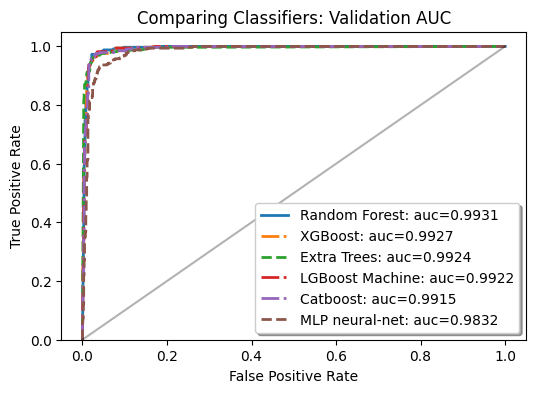

In [29]:
# Now that we have trained and tuned our ML models, we are ready to predict the
# validation set and examine the ML performance. We first print the validation set
# (20% held out of training) accuracy, as well as the F statistic  and the 2x2
# confusion matrix for Rforest, XGB, Etrees, Catboost, LGBM, and MLP-net models.
# We then visualize the AUC statistic with the ROC curve. We also examine the
# results of a blended PyCaret model. 

exec(open('ML_sdms_predict.py').read())

In [30]:
# Validation set F-statistic for the models above, as well as with a blended
# model. We find Random Forest is the winner in terms of validation AUC and
# F-stat, as well as with 10-fold Precision. Extra trees performs second best
# when considering 10-fold CV and validation performance.

f_score 

,RForest,LGBM,Catboost,Blended,Extra Trees,XGBoost,MLP-net
F-statistic :,0.949555,0.94362,0.941349,0.940653,0.94012,0.939079,0.900145


### Geospatial Predictions of Species Distributions
---

In [31]:
# updated pyimpute functions for spatial prediction
exec(open('_main.py').read())

In [32]:
import glob 
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
# grab features
explanatory_rasters = sorted(glob.glob(
    '/Users/danielfurman/Data_science_code/xantusia-data-main/train_tifs/bclim*.asc'))

print('\nThere are', len(explanatory_rasters), '.asc features.') # check there are ten 
# grab geojson of presences/absences
response_data = gpd.GeoDataFrame.from_file(
    '/Users/danielfurman/Data_science_code/xantusia-data-main/points_xv/points_xv.shp') 
response_data.head(3) # check geojson


There are 10 .asc features.


,longitude,latitude,pa,geometry
0,-118.527201,34.798079,1.0,POINT (-118.52720 34.79808)
1,-113.778800,37.167000,1.0,POINT (-113.77880 37.16700)
2,-118.123244,35.737211,1.0,POINT (-118.12324 35.73721)


In [33]:
# create pyimpute framework with presences/absences geojson and feature rasters
train_xs, train_y = load_training_vector(response_data,
                                         explanatory_rasters,
                                         response_field='pa') 
# train_xs.shape, train_y.shape # check shape
target_xs, raster_info = load_targets(explanatory_rasters)
# spatial prediction with impute function, saves tifs to file
impute(target_xs, rf, raster_info, 
       outdir="/Users/danielfurman/Data_science_code/ensemble-climate-projections", 
       class_prob=True, certainty=True)

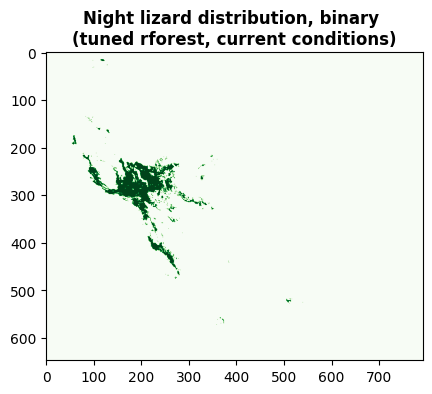

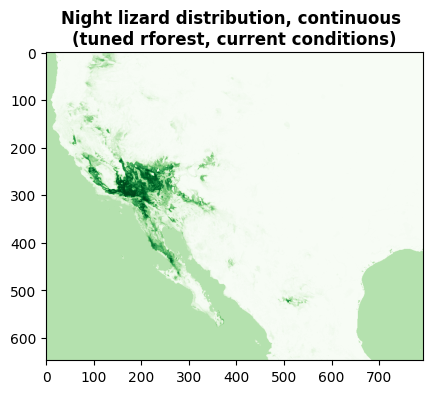

In [34]:
# plot the spatial outputs
rf_curr = rasterio.open("responses.tif") 
plt.imshow(rf_curr.read(1), cmap='Greens')
plt.title('Night lizard distribution, binary \n(tuned rforest, current conditions)',
          fontweight ='bold')
plt.figure()
rf_curr = rasterio.open("probability_1.tif") 
plt.imshow(rf_curr.read(1), cmap = 'Greens')
plt.title('Night lizard distribution, continuous \n(tuned rforest, current conditions)',
          fontweight ='bold')
print('')